### UNSUPERVISED LEARNING

EDSA Movie Recommendation Wilderness Flex your Unsupervised Learning skills to generate movie recommendations from the wilderness of data available!

### algorithms can help viewers find great titles from tens of thousands of options.
EDSA is challenging you to construct a recommendation algorithm based on content or collaborative filtering, capable of accurately predicting how a user will rate a movie they have not yet viewed, based on their historical preferences.

Collaborative filtering is a recommendation system that creates a prediction based on a user’s previous behaviors.

### Collaborative filtering (CF) and its modifications is one of the most commonly used recommendation algorithms.
To understand the recommender system better, it is a must to know that there are three approaches to it being:

Content-based filtering, Collaborative filtering, Hybrid model

In [1]:
!pip install comet_ml

In [1]:
# import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="jqo20ptaA2zzIEpvXms0ZcjVz",
    project_name="Recommender Systems PREDICT",
    workspace="skchanny",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/skchanny/recommender-systems-predict/6bdd89bcfec64f2e8068b92dc9db46a8

COMET INFO: Couldn't find a Git repository in 'C:\\Users\\HIFI CORP THAVHANI\\Desktop\\EXPLORE DATA SCIENCE\\SPRINT\\UNSUPERVISED LEARNING\\PREDICT' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`


In [ ]:
!pip install numpy


In [4]:
!pip install scikit-surprise

In [2]:
import numpy as np
import pandas as pd
#import graphlab # converting data for collaborative filtering processing
import cufflinks as cf
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt ## for data visusalisation
import seaborn as sns ## for data visualisation
%matplotlib inline
import os ##for loading data (csv files e.t.c)

import surprise
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import KNNWithMeans

#Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator # <-- Convienient item retrieval during iteration 
import heapq # <-- Efficient sorting of large lists

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


from IPython import display
from IPython.display import Image

# Packages for saving models
import pickle

In [3]:
df = pd.read_csv("movies.csv")# load the data
mdb_df = pd.read_csv("imdb_data.csv")
train_df = pd.read_csv("train.csv")
tag_df = pd.read_csv("tags.csv")
link_df = pd.read_csv("links.csv")
gen_df = pd.read_csv("genome_scores.csv")
gentag_df = pd.read_csv("genome_tags.csv")

In [4]:
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
df1 = df.copy()

In [6]:
mdb_df.head()

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game
2,3,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,101.0,"$25,000,000",boat|lake|neighbor|rivalry
3,4,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,124.0,"$16,000,000",black american|husband wife relationship|betra...
4,5,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,106.0,"$30,000,000",fatherhood|doberman|dog|mansion


In [7]:
mdb_df1 = mdb_df.copy()

In [8]:
train_df.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [9]:
train_df1 = train_df.copy()

Average rating in dataset: 3.5333951730983424


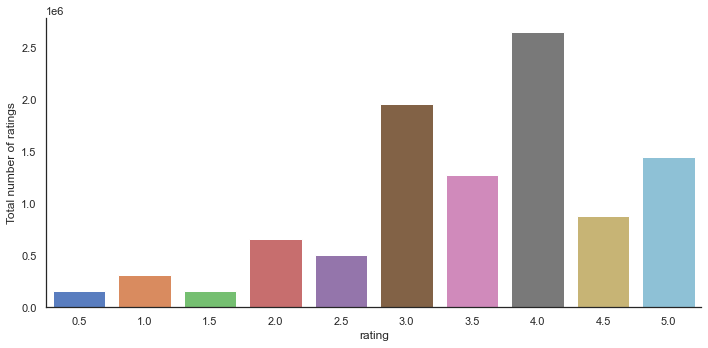

In [10]:
#Distribution of ratings
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=train_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings")
print (f'Average rating in dataset: {np.mean(train_df1["rating"])}')

We can see that there are more than 35000 ratings with score 4.0 and this is the rating with many users followed by 3.0 > 5.0 > 3.5 > 4.5 >2.0 > 2.5 > 1.0

The average rating is 3.5

In [15]:
#Create a list of dataframes to be merged
dfs = [df1,mdb_df1,train_df1]

In [16]:
from functools import reduce

In [17]:
#merging the 3 dataframes on column = movieId
df_final = reduce(lambda left,right: pd.merge(left,right,on='movieId'), dfs)

In [18]:
df_final.head()

,movieId,title,genres,title_cast,director,runtime,budget,plot_keywords,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,158849,5.0,994716786
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,97203,5.0,942683155
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,161871,3.0,833104576
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,45117,4.0,1442256969
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation,27431,5.0,849667827


In [19]:
df_final.shape

(9633031, 11)

In [20]:
#Checking for missing values
df_final.isna().sum()

movieId                0
title                  0
genres                 0
title_cast       2604407
director         2602688
runtime          2653058
budget           3152276
plot_keywords    2610043
userId                 0
rating                 0
timestamp              0
dtype: int64

In [21]:
#check null values
round((df_final.isnull().sum()/df_final.shape[0])*100,2).astype(str)+ '%'


movieId            0.0%
title              0.0%
genres             0.0%
title_cast       27.04%
director         27.02%
runtime          27.54%
budget           32.72%
plot_keywords    27.09%
userId             0.0%
rating             0.0%
timestamp          0.0%
dtype: object

In [22]:
#Drop columns
#df_final = df_final.drop(['title_cast','director','runtime','budget','plot_keywords'], axis=1)
#df_final.head()
#Qn. What about title_cast column since some movies can be recommended based on the actor

In [23]:
df_final.shape

(9633031, 11)

In [ ]:
df_final

In [12]:
tag_df.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [13]:
link_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [14]:
gen_df.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [15]:
gentag_df.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [24]:
CBA_df = df_final[['title','genres','title_cast','director','plot_keywords']]
CBA_df= CBA_df.drop_duplicates(subset=["title"],keep = 'first')
new_df = CBA_df[:2000] #Dealing with big data, take a subset of the data for easy processing

In [25]:
new_df.head()

,title,genres,title_cast,director,plot_keywords
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation
23062,Jumanji (1995),Adventure|Children|Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game
32716,Grumpier Old Men (1995),Comedy|Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry
37443,Waiting to Exhale (1995),Comedy|Drama|Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...
38411,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion


### Data pre-processing

In [26]:
import re

In [27]:
#Removing the pipes (|)
def preprocess_genre(genre):
    "This function removes concatenation"
    genre = re.sub(r'[\-]', '_', genre)
    genre = re.sub(r'[\(\)]', '', genre)
    genre = re.sub(r'no genres listed', 'no_genres_listed', genre)
    genre = ' '.join([word for word in genre.split('|')])
    return genre

In [28]:
new_df['genres'] = new_df['genres'].apply(preprocess_genre)

In [29]:
new_df.head()

,title,genres,title_cast,director,plot_keywords
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation
23062,Jumanji (1995),Adventure Children Fantasy,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,board game|adventurer|fight|game
32716,Grumpier Old Men (1995),Comedy Romance,Walter Matthau|Jack Lemmon|Sophia Loren|Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry
37443,Waiting to Exhale (1995),Comedy Drama Romance,Whitney Houston|Angela Bassett|Loretta Devine|...,Terry McMillan,black american|husband wife relationship|betra...
38411,Father of the Bride Part II (1995),Comedy,Steve Martin|Diane Keaton|Martin Short|Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion


In [30]:
def preprocess_titlecast(title_cast):
    title_cast = re.sub(r'\ ', '_', str(title_cast))
    title_cast = ' '.join([word for word in title_cast.split('|')])
    return title_cast

In [31]:
new_df['title_cast'] = new_df['title_cast'].apply(preprocess_titlecast)

In [32]:
new_df.head()

,title,genres,title_cast,director,plot_keywords
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John Lasseter,toy|rivalry|cowboy|cgi animation
23062,Jumanji (1995),Adventure Children Fantasy,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan Hensleigh,board game|adventurer|fight|game
32716,Grumpier Old Men (1995),Comedy Romance,Walter_Matthau Jack_Lemmon Sophia_Loren Ann-Ma...,Mark Steven Johnson,boat|lake|neighbor|rivalry
37443,Waiting to Exhale (1995),Comedy Drama Romance,Whitney_Houston Angela_Bassett Loretta_Devine ...,Terry McMillan,black american|husband wife relationship|betra...
38411,Father of the Bride Part II (1995),Comedy,Steve_Martin Diane_Keaton Martin_Short Kimberl...,Albert Hackett,fatherhood|doberman|dog|mansion


In [33]:
def preprocess_director(director):
    director = re.sub(r'\ ', '_', str(director))
    return director


In [34]:
new_df['director'] = new_df['director'].apply(preprocess_director)

In [35]:
new_df.head()

,title,genres,title_cast,director,plot_keywords
0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Tom_Hanks Tim_Allen Don_Rickles Jim_Varney Wal...,John_Lasseter,toy|rivalry|cowboy|cgi animation
23062,Jumanji (1995),Adventure Children Fantasy,Robin_Williams Jonathan_Hyde Kirsten_Dunst Bra...,Jonathan_Hensleigh,board game|adventurer|fight|game
32716,Grumpier Old Men (1995),Comedy Romance,Walter_Matthau Jack_Lemmon Sophia_Loren Ann-Ma...,Mark_Steven_Johnson,boat|lake|neighbor|rivalry
37443,Waiting to Exhale (1995),Comedy Drama Romance,Whitney_Houston Angela_Bassett Loretta_Devine ...,Terry_McMillan,black american|husband wife relationship|betra...
38411,Father of the Bride Part II (1995),Comedy,Steve_Martin Diane_Keaton Martin_Short Kimberl...,Albert_Hackett,fatherhood|doberman|dog|mansion


In [36]:
def preprocess_keywords(keywords):
    keywords = ' '.join([word for word in str(keywords).split('|')])
    return keywords


In [37]:
new_df['plot_keywords'] = new_df['plot_keywords'].apply(preprocess_keywords)

In [38]:
new1_df = (pd.Series(new_df[['genres', 'title_cast','director', 'plot_keywords']]
                      .fillna('')
                      .values.tolist()).str.join(' '))

In [39]:
new1_df.head()

0    Adventure Animation Children Comedy Fantasy To...
1    Adventure Children Fantasy Robin_Williams Jona...
2    Comedy Romance Walter_Matthau Jack_Lemmon Soph...
3    Comedy Drama Romance Whitney_Houston Angela_Ba...
4    Comedy Steve_Martin Diane_Keaton Martin_Short ...
dtype: object

In [40]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/skchanny/recommender-systems-predict/6bdd89bcfec64f2e8068b92dc9db46a8
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish before aborting...
COMET INFO: Still uploading 2 file(s), remaining 28.29 KB/28.29 KB
